In [ ]:
import azure.storage.blob
from azure.storage.blob import BlobServiceClient
import pandas as pd
import json
import base64

# Azure setup
connection_string = "DefaultEndpointsProtocol=https;AccountName=pipicostorage;AccountKey=********==;EndpointSuffix=core.windows.net"
container_name = "sensor-data"
folder_prefix = "pipicotest/00/2025/04/18/"

In [ ]:
# DataFrame
df = pd.DataFrame(columns=['enqueued_time_utc', 'device_id', 'adc_value', 'temperature', 'voltage'])

# Blobs processing
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

for blob in container_client.list_blobs(name_starts_with=folder_prefix):
    try:
        blob_content = blob_service_client.get_blob_client(
            container=container_name,
            blob=blob.name
        ).download_blob().readall().decode('utf-8')
        
        for line in blob_content.splitlines():
            if line.strip():
                message = json.loads(line)
                sensor_data = json.loads(base64.b64decode(message['Body']).decode('utf-8'))
                
                df = pd.concat([df, pd.DataFrame([{
                    'enqueued_time_utc': pd.to_datetime(message['EnqueuedTimeUtc']),
                    'device_id': message['SystemProperties']['connectionDeviceId'],
                    'adc_value': sensor_data.get('adc_value'),
                    'temperature': sensor_data.get('temperature'),
                    'voltage': sensor_data.get('voltage')
                }])], ignore_index=True)

    except Exception:
        continue

df["enqueued_time_cte"] = df["enqueued_time_utc"].dt.tz_convert("Europe/Prague")  
df.drop(columns=["enqueued_time_utc"], inplace=True)  

C:\Users\david\AppData\Local\Temp\ipykernel_6208\46367118.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([{


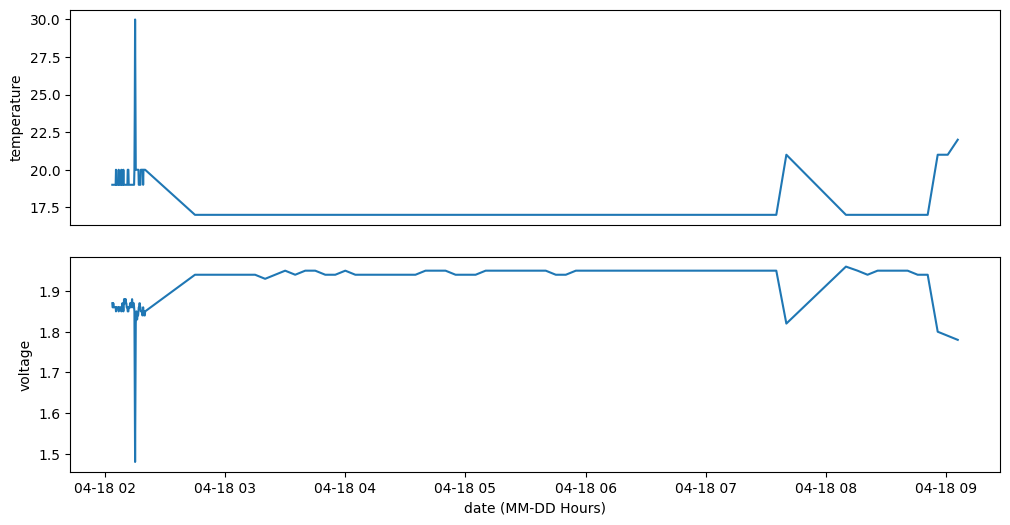

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

sns.lineplot(data=df, x='enqueued_time_cte', y='temperature', ax=ax1)
sns.lineplot(data=df, x='enqueued_time_cte', y='voltage', ax=ax2)

plt.subplots_adjust(hspace=0.15)

ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_xlabel("")
ax2.set_xlabel("date (MM-DD Hours)")

plt.show()